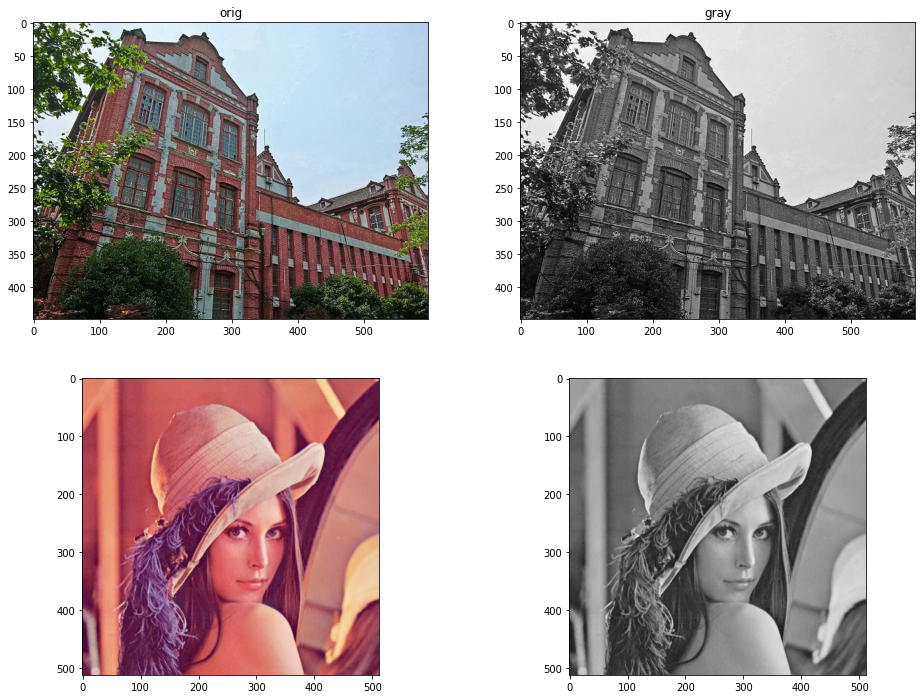

In [1]:
import cv2;
import numpy as np;
import matplotlib.pyplot as plt
from utils import gray_to_color, show_images


image_sjtu = cv2.imread("images/sjtu.jpeg")
image_sjtu  = cv2.cvtColor(image_sjtu, cv2.COLOR_BGR2RGB)
image_sjtu_gray  = cv2.cvtColor(image_sjtu, cv2.COLOR_RGB2GRAY)

image_lena = cv2.imread("images/lena.png")
image_lena = cv2.cvtColor(image_lena, cv2.COLOR_BGR2RGB)
image_lena_gray = cv2.cvtColor(image_lena, cv2.COLOR_RGB2GRAY)

images = [image_sjtu, gray_to_color(image_sjtu_gray), image_lena, gray_to_color(image_lena_gray)]
show_images(2,2, images, (16, 12), ["orig", "gray"])

# 3 Intensity Transformations and Spatial Filtering

## 3.2 Some Basic Intensity Transformation Functions

/var/folders/xv/z_xcbffn1cv5j8vwh1xwqnpw0000gn/T/ipykernel_75805/1948384836.py:5: RuntimeWarning: divide by zero encountered in log10
  image2 = 6 * np.log10(image_sjtu_gray + 1) # c * log (r + 1)


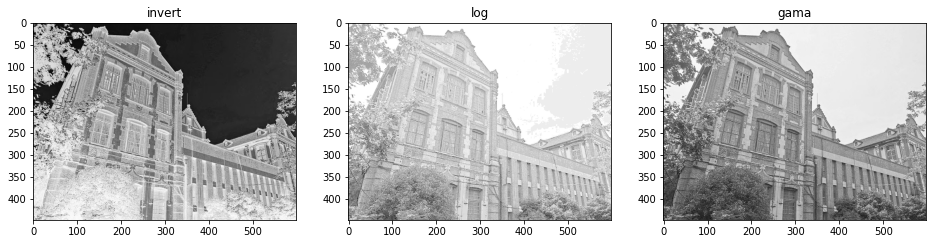

In [2]:
# image negative
image1 = 255 - image_sjtu_gray

# log transformation
image2 = 6 * np.log10(image_sjtu_gray + 1) # c * log (r + 1)
image2 = image2.astype(np.uint8)
image2 = cv2.normalize(image2, image2, 0, 255, cv2.NORM_MINMAX)
image2 = cv2.convertScaleAbs(image2)

# power-law (gamma) transformations
image3 = 6 * np.power(image_sjtu_gray, 0.5) # c * r^\gama
image3 = cv2.normalize(image3, image2, 0, 255, cv2.NORM_MINMAX)
image3 = cv2.convertScaleAbs(image3)

images = [image1, image2, image3]
images = [gray_to_color(img) for img in images]
show_images(1, 3, images, titles=["invert", "log", "gama"])


## 3.3 HISTOGRAM PROCESSING

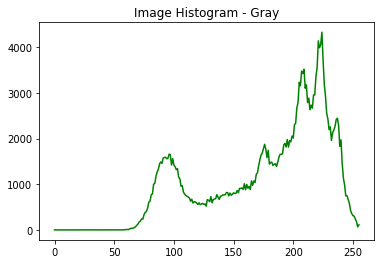

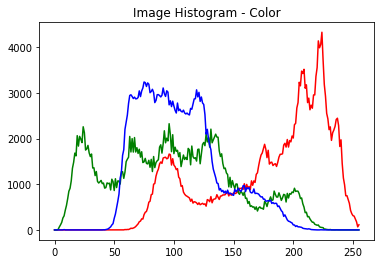

In [3]:
# histogram (gray)
hist = cv2.calcHist(
    [image_lena], # images
    [0], # channels
    None, [256], [0, 256]
)
plt.plot(hist, color='g')
plt.title("Image Histogram - Gray")
plt.show()

# histogram (color)
for i,color in enumerate(('r', 'g', 'b')):
    hist = cv2.calcHist([image_lena],[i],None,[256],[0,256])
    plt.plot(hist,color = color)
plt.title('Image Histogram - Color')
plt.show()


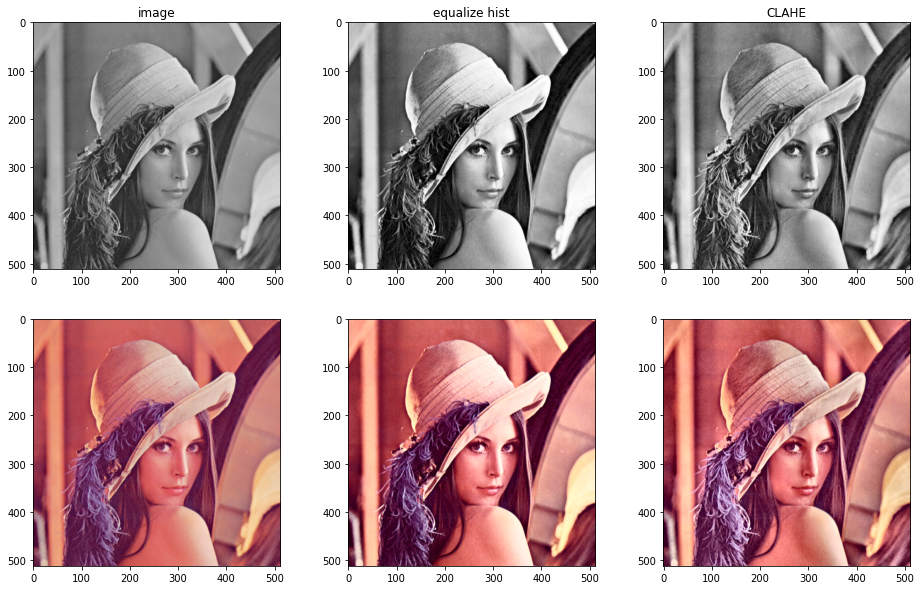

In [4]:
# histogram equalization (gray)
image1 = cv2.equalizeHist(image_lena_gray) # y channel

# histogram equalization (gray, CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image11 = clahe.apply(image_lena_gray)

# histogram equalization (color)
image2 = cv2.cvtColor(image_lena, cv2.COLOR_RGB2YUV) # convert to yuv
image2[:,:,0] = cv2.equalizeHist(image2[:,:,0]) # y channel
image2 = cv2.cvtColor(image2, cv2.COLOR_YUV2RGB)

# histogram equalization (color, CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image21 = cv2.cvtColor(image_lena, cv2.COLOR_RGB2YUV) # convert to yuv
image21[:,:,0] = clahe.apply(image21[:,:,0])
image21 = cv2.cvtColor(image21, cv2.COLOR_YUV2RGB)

images = [
    gray_to_color(image_lena_gray), gray_to_color(image1), gray_to_color(image11),
    image_lena, image2, image21
]
show_images(2, 3, images, (16, 10), titles=["image", "equalize hist", "CLAHE"])

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


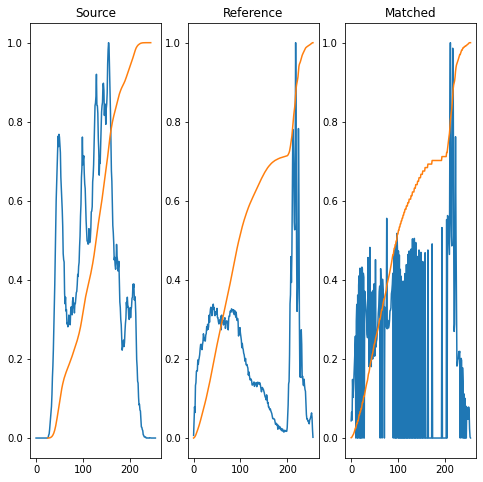

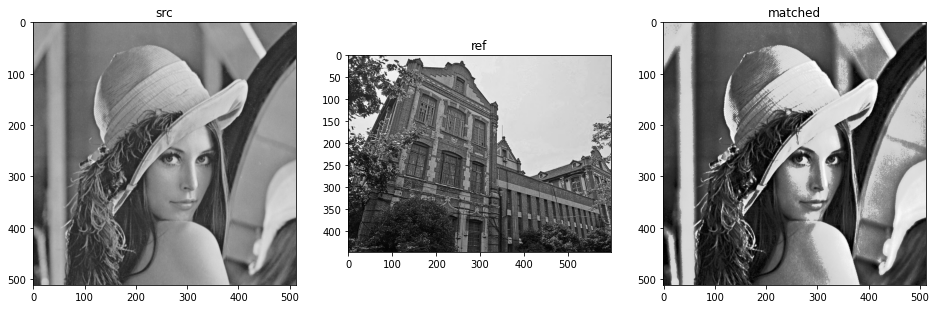

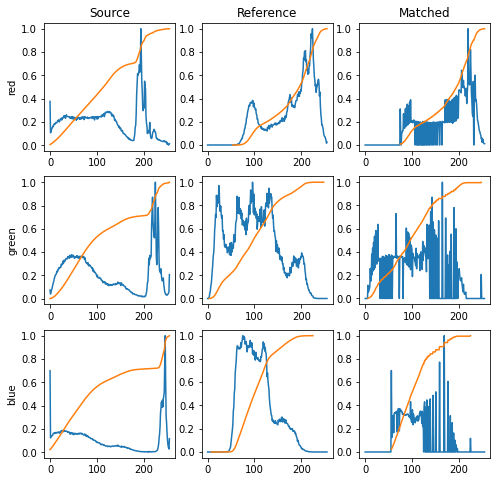

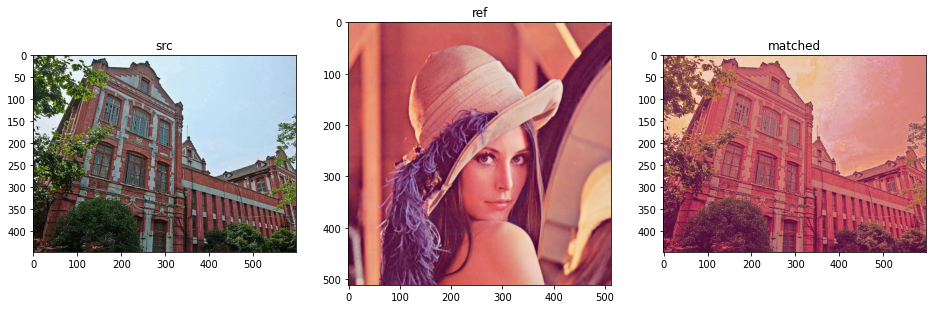

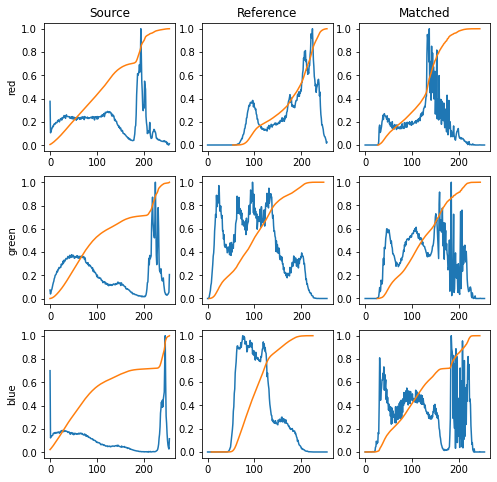

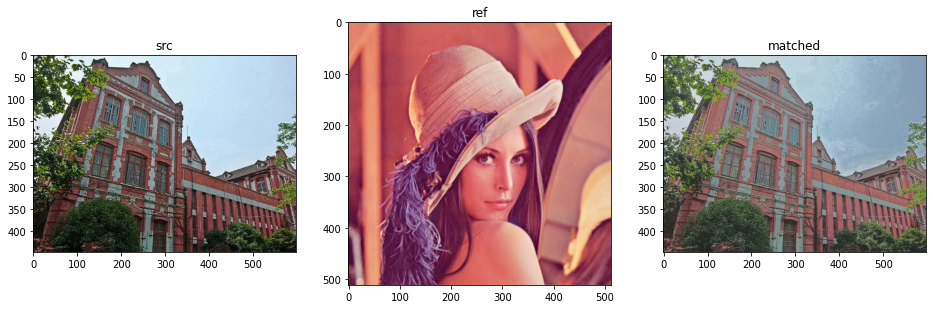

In [5]:
# histogram matching
!{sys.executable} -m pip install scikit-image -i https://pypi.tuna.tsinghua.edu.cn/simple/
from skimage import exposure

def show_histogram_diff_color(src, ref, matched):
    (fig, axs) =  plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
    axs[0, 0].set_title("Source")
    axs[0, 1].set_title("Reference")
    axs[0, 2].set_title("Matched")
    for (i, image) in enumerate((src, ref, matched)):
        for (j, color) in enumerate(("red", "green", "blue")):
            (hist, bins) = exposure.histogram(image[..., j], source_range="dtype")
            axs[j, i].plot(bins, hist / hist.max())
            (cdf, bins) = exposure.cumulative_distribution(image[..., j])
            axs[j, i].plot(bins, cdf)
            axs[j, 0].set_ylabel(color)

def show_histogram_diff_grey(src, ref, matched):
    (fig, axs) =  plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
    axs[0].set_title("Source")
    axs[1].set_title("Reference")
    axs[2].set_title("Matched")
    for (i, image) in enumerate((src, ref, matched)):
        (hist, bins) = exposure.histogram(image, source_range="dtype")
        axs[i].plot(bins, hist / hist.max())
        (cdf, bins) = exposure.cumulative_distribution(image)
        axs[i].plot(bins, cdf)


# histogram matching (gray)
ref_img = image_sjtu_gray
src_img = image_lena_gray
image1 = exposure.match_histograms(src_img, ref_img)
image1 = image1.astype(np.uint8)
show_histogram_diff_grey(src_img, ref_img, image1)

images = [src_img, ref_img, image1]
images = [gray_to_color(img) for img in images]
show_images(1, 3, images, titles=["src", "ref", "matched"])

# histogram matching, color, algorithm 1
image2 = exposure.match_histograms(image_sjtu, image_lena, channel_axis=2)
show_histogram_diff_color(image_sjtu, image_lena, image2)
images = [image_sjtu, image_lena, image2]
show_images(1, 3, images, titles=["src", "ref", "matched"])

# histogram matching, color, algorithm 2
ref_img = cv2.cvtColor(image_lena, cv2.COLOR_RGB2YUV)
image3 = cv2.cvtColor(image_sjtu, cv2.COLOR_RGB2YUV)
image3[:,:,0] = exposure.match_histograms(image3[:,:,0], ref_img[:,:,0])
image3 = cv2.cvtColor(image3, cv2.COLOR_YUV2RGB)
show_histogram_diff_color(image_sjtu, image_lena, image3)
images = [image_sjtu, image_lena, image3]
show_images(1, 3, images, titles=["src", "ref", "matched"])


# 4 Filtering in the Frequency Domain

## 4.8 IMAGE SMOOTHING USING LOWPASS FREQUENCY DOMAIN FILTERS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


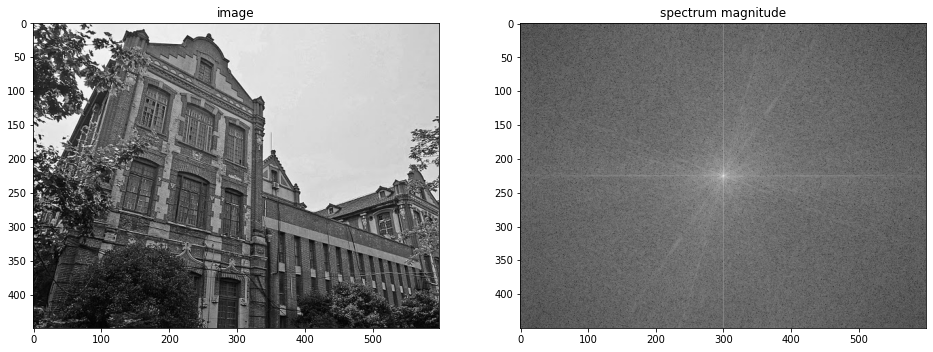

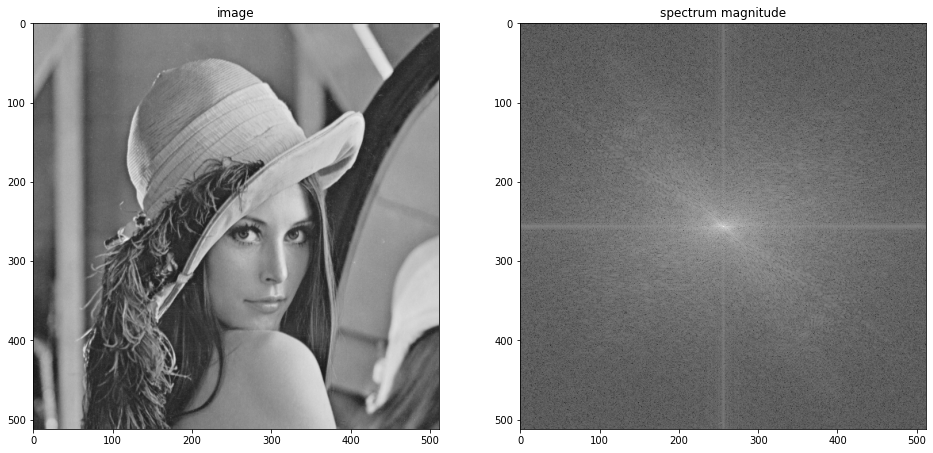

In [6]:

def draw_dft(image):
    rows, cols = image.shape
    m = cv2.getOptimalDFTSize( rows )
    n = cv2.getOptimalDFTSize( cols )
    padded = cv2.copyMakeBorder(image, 0, m - rows, 0, n - cols, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    planes = [np.float32(padded), np.zeros(padded.shape, np.float32)]
    complexI = cv2.merge(planes)         # Add to the expanded another plane with zeros

    cv2.dft(complexI, complexI)         # this way the result may fit in the source matrix

    cv2.split(complexI, planes)                   # planes[0] = Re(DFT(I), planes[1] = Im(DFT(I))
    cv2.magnitude(planes[0], planes[1], planes[0])# planes[0] = magnitude
    magI = planes[0]

    matOfOnes = np.ones(magI.shape, dtype=magI.dtype)
    cv2.add(matOfOnes, magI, magI) #  switch to logarithmic scale
    cv2.log(magI, magI)

    magI_rows, magI_cols = magI.shape
    # crop the spectrum, if it has an odd number of rows or columns
    magI = magI[0:(magI_rows & -2), 0:(magI_cols & -2)]
    cx = int(magI_rows/2)
    cy = int(magI_cols/2)
    q0 = magI[0:cx, 0:cy]         # Top-Left - Create a ROI per quadrant
    q1 = magI[cx:cx+cx, 0:cy]     # Top-Right
    q2 = magI[0:cx, cy:cy+cy]     # Bottom-Left
    q3 = magI[cx:cx+cx, cy:cy+cy] # Bottom-Right
    tmp = np.copy(q0)               # swap quadrants (Top-Left with Bottom-Right)
    magI[0:cx, 0:cy] = q3
    magI[cx:cx + cx, cy:cy + cy] = tmp
    tmp = np.copy(q1)               # swap quadrant (Top-Right with Bottom-Left)
    magI[cx:cx + cx, 0:cy] = q2
    magI[0:cx, cy:cy + cy] = tmp

    cv2.normalize(magI, magI, 0, 1, cv2.NORM_MINMAX) # Transform the matrix with float values into a

    show_images(1, 2, [gray_to_color(image), gray_to_color(magI)], titles=["image", "spectrum magnitude"])

draw_dft(image_sjtu_gray)
draw_dft(image_lena_gray)